In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import datetime as dt

In [2]:
# Load the data
file_path = '../../../Dataset/ETH-USD.csv'
df = pd.read_csv(file_path, parse_dates=True, index_col=0)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-03-01,856.012024,880.302002,851.919983,872.200012,872.200012,1868519936
2018-03-02,871.763977,876.377991,852.421997,856.853027,856.853027,1894419968
2018-03-03,856.710999,868.453979,855.206970,857.224976,857.224976,1699369984
2018-03-04,856.185974,867.950012,840.280029,866.677979,866.677979,1697939968
2018-03-05,866.846008,869.919983,853.520020,853.684021,853.684021,1898489984


In [3]:
# Feature Engineering
def createFeatures(df):
    df = pd.DataFrame(df)

    
    # df['Close_Diff'] = df['Adj Close'].diff()
        
    # Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA26'] = df['Close'].rolling(window=26).mean() 
    df['MA20'] = df['Close'].rolling(window=20).mean() 
    df['MA12'] = df['Close'].rolling(window=12).mean() 
    
    # SMA Differences - different periods
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
    df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
    df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']
    df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
    df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']
    
    # Moving Averages on high, lows, and std - different periods
    # df['MA200_low'] = df['Low'].rolling(window=200).min()
    # df['MA14_low'] = df['Low'].rolling(window=14).min()
    # df['MA200_high'] = df['High'].rolling(window=200).max()
    # df['MA14_high'] = df['High'].rolling(window=14).max()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std() 
    
    # Exponential Moving Averages (EMAS) - different periods
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Shifts (one day before and two days before)
    df['close_shift-1'] = df.shift(-1)['Close']
    df['close_shift-2'] = df.shift(-2)['Close']

    # Bollinger Bands
    df['Bollinger_Upper'] = df['MA20'] + (df['MA20dSTD'] * 2)
    df['Bollinger_Lower'] = df['MA20'] - (df['MA20dSTD'] * 2)
    df['Bollinger_Middle'] = df['MA20'] 
    
    # Relative Strength Index (RSI)
    # df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    # Relative Strength Index (RSI) not using the K-ratio
    # df['RSI'] = df['K-ratio'].rolling(window=3).mean() 

    # Moving Average Convergence/Divergence (MACD)
    df['MACD'] = df['EMA12'] - df['EMA26']
    
    # Replace nas 
    nareplace = df.at[df.index.max(), 'Close']    
    df.fillna((nareplace), inplace=True)
    
    # 
    return df

                 Close      MACD  Bollinger_Upper  Bollinger_Lower        MA26       EMA20
Date                                                                                      
2018-10-02  227.181000 -5.729216       248.675597       199.022404  217.482077  228.975856
2018-10-03  220.488998 -5.855122       248.492314       200.119187  217.608461  228.167584
2018-10-04  222.218002 -5.749115       248.314508       201.343894  218.541807  227.600957
2018-10-05  227.600998 -5.171132       248.556886       201.554214  219.721692  227.600961
2018-10-06  225.119995 -4.857280       248.689311       201.874888  220.800192  227.364678


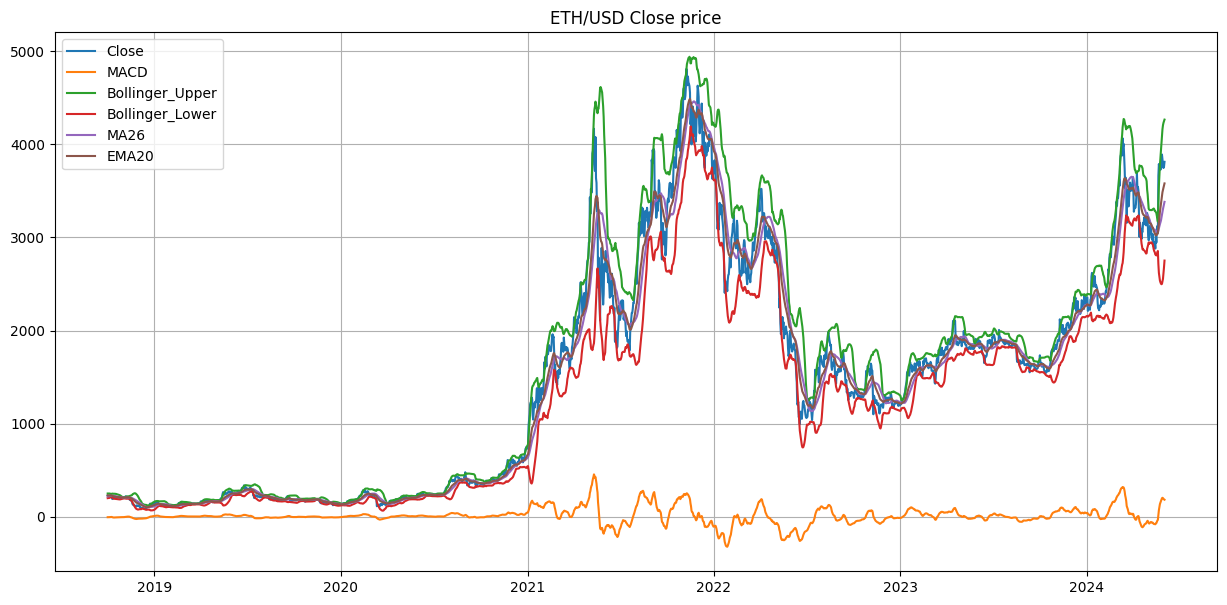

In [4]:
# List of considered Features
FEATURES = [
            # 'High',
            # 'Low',
            # 'Open',
            'Close',
            # 'Volume',
#             'Day',
#             'Month',
#             'Year',
            # 'Adj Close',
#              'close_shift-1',
#              'close_shift-2',
            'MACD',
            # 'RSI',
            # 'MA200',
#             'MA200_high',
#             'MA200_low',
            'Bollinger_Upper',
            'Bollinger_Lower',
            # 'MA100',            
#             'MA50',
            'MA26',
#             'MA14_low',
#             'MA14_high',
            # 'MA12',
            'EMA20',
            # 'EMA100',
#             'EMA200',
#               'DIFF-MA200-MA50',
#               'DIFF-MA200-MA100',
#             'DIFF-MA200-CLOSE',
#             'DIFF-MA100-CLOSE',
#             'DIFF-MA50-CLOSE',
            # 'MA20dSTD',
            # 'Close_Diff',
            # 'K-ratio'
           ]
# Create the dataset with features
df_features = createFeatures(df)

# Shift the timeframe by 10 month -> Start date is 2010-11-01
use_start_date = pd.to_datetime("2018-10-01")
df_features = df_features[df_features.index > use_start_date].copy()

# Filter the data to the list of FEATURES
df_filtered = df_features[FEATURES].copy()
# Filter the data to the list of FEATURES
df_filtered = df_filtered.dropna()
# Filter the data to the list of FEATURES
print(df_filtered.head().to_string())  
    

# Create the lineplot
plt.style.use('default')
plt.figure(figsize=(15, 7))
plt.plot(df_filtered)
plt.title('ETH/USD Close price')
plt.grid()
plt.legend(df_filtered.columns)
plt.show()

In [5]:
# Training and Test dataset
test_size = 0.3
train_size = int(len(df_filtered) * (1 - test_size))
train, test = df_filtered.iloc[0:train_size], df_filtered.iloc[train_size:len(df_filtered)]

In [6]:
X_train = train.drop('Close', axis=1)
y_train = train['Close']

X_test = test.drop('Close', axis=1)
y_test = test['Close']


In [7]:
# XGBoost
# XGBoost Regressor
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train
        , y_train
        , eval_set=[(X_train, y_train), (X_test, y_test)]
        , early_stopping_rounds=50
       )

[0]	validation_0-rmse:931.33021	validation_1-rmse:756.24406
[1]	validation_0-rmse:661.35404	validation_1-rmse:554.34488
[2]	validation_0-rmse:471.76033	validation_1-rmse:396.54340
[3]	validation_0-rmse:338.57700	validation_1-rmse:290.69039
[4]	validation_0-rmse:245.69863	validation_1-rmse:225.20928
[5]	validation_0-rmse:181.36126	validation_1-rmse:184.99666
[6]	validation_0-rmse:136.61575	validation_1-rmse:163.50556
[7]	validation_0-rmse:106.43511	validation_1-rmse:151.96211
[8]	validation_0-rmse:85.68934	validation_1-rmse:146.03755
[9]	validation_0-rmse:71.48963	validation_1-rmse:143.87733
[10]	validation_0-rmse:61.79563	validation_1-rmse:145.06090
[11]	validation_0-rmse:56.28927	validation_1-rmse:144.19753
[12]	validation_0-rmse:52.20942	validation_1-rmse:146.22076
[13]	validation_0-rmse:48.70308	validation_1-rmse:146.46138
[14]	validation_0-rmse:45.13758	validation_1-rmse:147.22175
[15]	validation_0-rmse:43.75506	validation_1-rmse:147.21076
[16]	validation_0-rmse:41.94564	validation

C:\Users\lequo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[56]	validation_0-rmse:18.48695	validation_1-rmse:148.89188
[57]	validation_0-rmse:18.31497	validation_1-rmse:148.82699
[58]	validation_0-rmse:17.64834	validation_1-rmse:147.73150
[59]	validation_0-rmse:17.60189	validation_1-rmse:147.72568


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

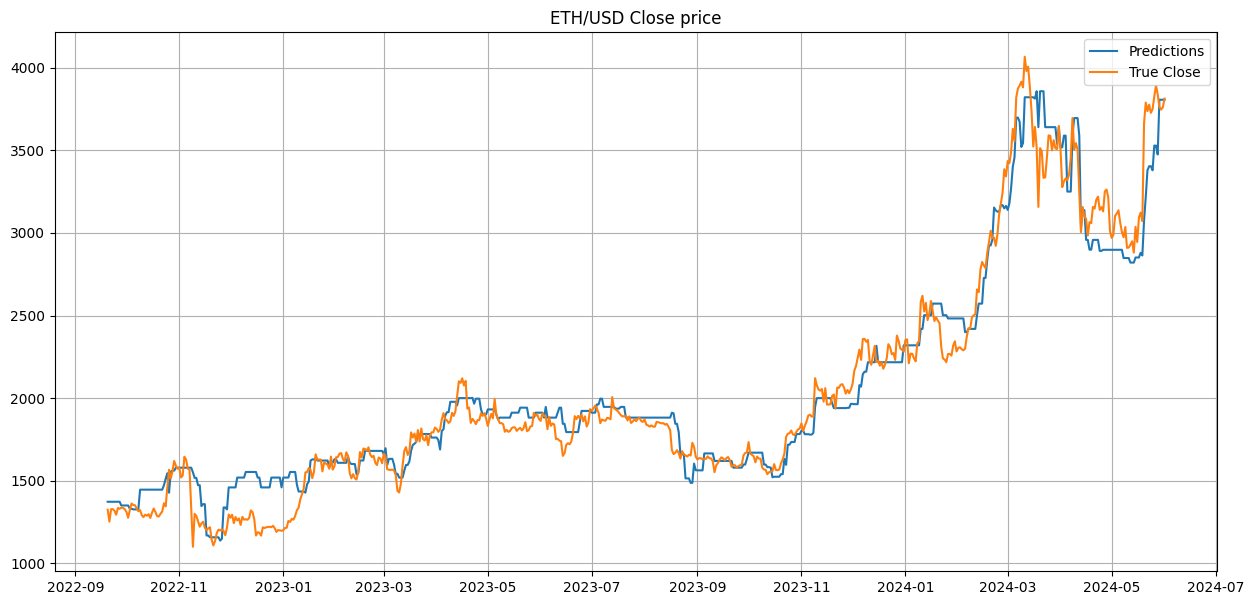

In [8]:
# Make predictions for validation and test sets
test_preds = reg.predict(X_test)

# plot the predictions
plt.figure(figsize=(15, 7))
plt.plot(test.index, test_preds, label='Predictions')
plt.plot(test.index, test['Close'], label='True Close')
plt.title('ETH/USD Close price')
plt.grid()
plt.legend()
plt.show()

In [9]:
# Create function to forecast next x days
def forecast_next_x_days(df, num_days, best_model):

    print(f"Forecasting for day {num_days}")
    # Predict 1 day ahead and use the forecasted value to create features for the next day
    df_forecast = df.copy()
    for i in range(num_days):
        # Create the forecast's exogenous variables
        lag_feature_input = df_forecast.iloc[-1].drop('Close').copy()
        print(f"Forecasting for day {i+1}")
        forecast_1_ahead = best_model.predict(lag_feature_input.values.reshape(1, -1))
        print(f"Forecasted value for day {i+1}: {forecast_1_ahead[0]}") 
        # Append the forecasted value to the dataset 
        lag_feature_input['Close'] = forecast_1_ahead[0]
        df_forecast_extend = pd.DataFrame([lag_feature_input], columns=df_forecast.columns)
        df_forecast = pd.concat([df_forecast, df_forecast_extend], axis=0)
        df_forecast.index = pd.date_range(start=df_forecast.index.min(), periods=len(df_forecast))
        # Create the features for the next day
        df_forecast = createFeatures(df_forecast)
        # Filter the data to the list of FEATURES
        df_forecast = df_forecast[FEATURES].copy()

        
    return df_forecast[-num_days:]

In [10]:
fc_90_day = forecast_next_x_days(df_filtered, 90, reg)
fc_60_day = forecast_next_x_days(df_filtered, 60, reg)
fc_30_day = forecast_next_x_days(df_filtered, 30, reg)

Forecasting for day 90
Forecasting for day 1
Forecasted value for day 1: 3806.447509765625
Forecasting for day 2
Forecasted value for day 2: 3791.427490234375
Forecasting for day 3
Forecasted value for day 3: 3559.125
Forecasting for day 4
Forecasted value for day 4: 3640.392822265625
Forecasting for day 5
Forecasted value for day 5: 3640.392822265625
Forecasting for day 6
Forecasted value for day 6: 3857.848876953125
Forecasting for day 7
Forecasted value for day 7: 3857.848876953125
Forecasting for day 8
Forecasted value for day 8: 3913.559814453125
Forecasting for day 9
Forecasted value for day 9: 3913.559814453125
Forecasting for day 10
Forecasted value for day 10: 3913.559814453125
Forecasting for day 11
Forecasted value for day 11: 3913.559814453125
Forecasting for day 12
Forecasted value for day 12: 3913.559814453125
Forecasting for day 13
Forecasted value for day 13: 3877.172607421875
Forecasting for day 14
Forecasted value for day 14: 3877.172607421875
Forecasting for day 15
F

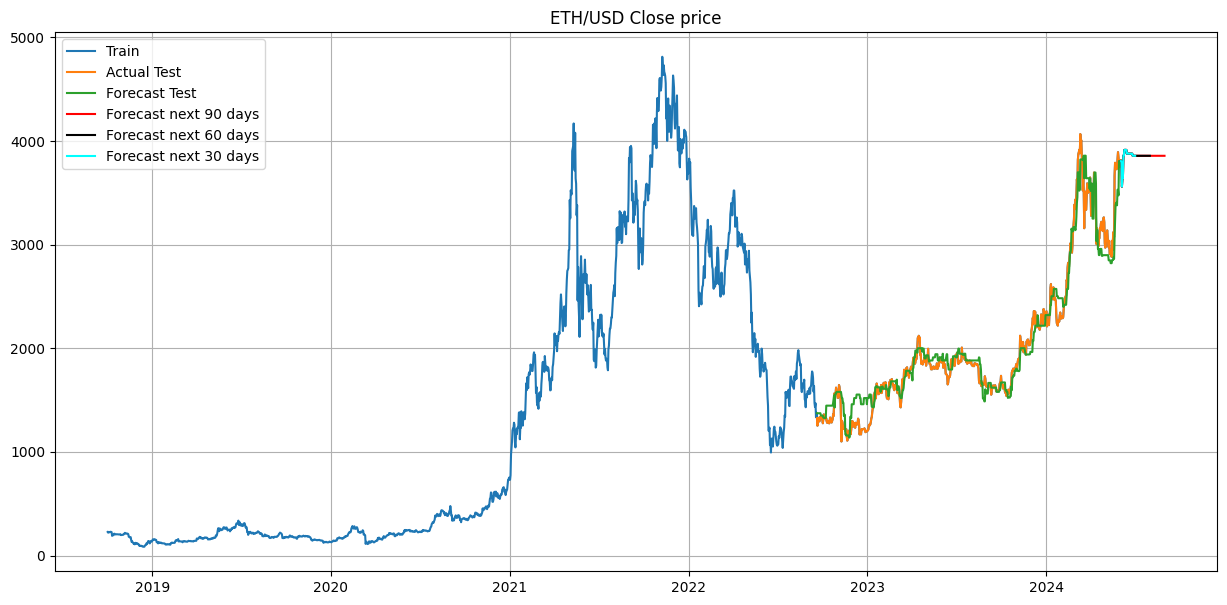

In [11]:
df_forecast_90 = fc_90_day.copy()
df_forecast_90.index = pd.date_range(start=df_filtered.index.max() + dt.timedelta(days=1), periods=len(df_forecast_90))

df_forecast_60 = fc_60_day.copy()
df_forecast_60.index = pd.date_range(start=df_filtered.index.max() + dt.timedelta(days=1), periods=len(df_forecast_60))

df_forecast_30 = fc_30_day.copy()
df_forecast_30.index = pd.date_range(start=df_filtered.index.max() + dt.timedelta(days=1), periods=len(df_forecast_30))


# Plot the overall with connection to forecast
plt.figure(figsize=(15, 7))
plt.plot(df_filtered['Close'], label='Train')
plt.plot(test.index, y_test, label='Actual Test')
plt.plot(test.index, test_preds, label='Forecast Test')
plt.plot(df_forecast_90.index, df_forecast_90['Close'], label='Forecast next 90 days', color='red')
plt.plot(df_forecast_60.index, df_forecast_60['Close'], label='Forecast next 60 days', color='black')
plt.plot(df_forecast_30.index, df_forecast_30['Close'], label='Forecast next 30 days', color='cyan')
plt.title('ETH/USD Close price')
plt.grid()
plt.legend()
plt.show()

In [12]:
# Calculate the Model's RMSE, MAPE, and SMAPE
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
    return rmse, mape, smape


# Calculate the metrics for the test data
rmse, mape, smape = calculate_metrics(y_test, test_preds)
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"SMAPE: {smape:.2f}")

RMSE: 143.88
MAPE: 5.54
SMAPE: 5.35
